In [35]:
import os
import numpy as np
import torch as pt
import matplotlib.pyplot as plt
from neo import AxonIO
from sklearn.neighbors import KernelDensity
from scipy.optimize import curve_fit
from scipy.signal import bessel, sosfiltfilt

In [2]:
def read_abf(filepath):
    # read file
    r = AxonIO(filepath)
    bl = r.read()

    # extract trace
    seg = bl[0].segments[0]
    I = np.array(seg.analogsignals[0]).ravel()
    V = np.array(seg.analogsignals[1]).ravel()
    dt = 1.0 / float(seg.analogsignals[0].sampling_rate)

    return I, V, dt

In [36]:
# define smoothing function
def smooth(x, dt):
    #bessel filter
    cutoff = 5000  # cutoff frequency in Hz
    order = 8  # order of the filter, for most general-purpose high- or low-pass filters, the terms pole and order may be used interchangeably and completely describe the rolloff rate
    # get the filter coefficients
    sos = bessel(order, cutoff, btype='lowpass', output='sos', fs=1.0/dt, norm='mag')  # mag: the filter is normalized such that the gain magnitude is -3dB at angular cutoff frequency
    # apply the filter with the filter coefficients
    return sosfiltfilt(sos, x)

In [3]:
def gauss(x, A, mu, sigma):
    return np.abs(A) * np.exp(-0.5*np.square((x - mu))/np.square(sigma))

In [4]:
def split_discont_ids(ids):
    ids = np.sort(ids).ravel()
    brk = np.where(np.diff(ids) > 1)[0]

    irng = np.concatenate([[-1], brk, [len(ids)-1]])

    ids_l = []
    for il, ih in zip(irng[:-1], irng[1:]):
        ids_l.append(ids[il+1:ih+1].ravel())

    return ids_l

In [5]:
filepath = 'raw_data/20220414-WTaSyn103140s/0414_WTaSyn103140_K238A_6_100mV/0414_WTaSyn103140_K238A_6_100mV_CH002_003.abf'

In [6]:
I, V, dt = read_abf(filepath)
dt = dt * 1e3  # ms
t = np.arange(I.shape[0])*dt

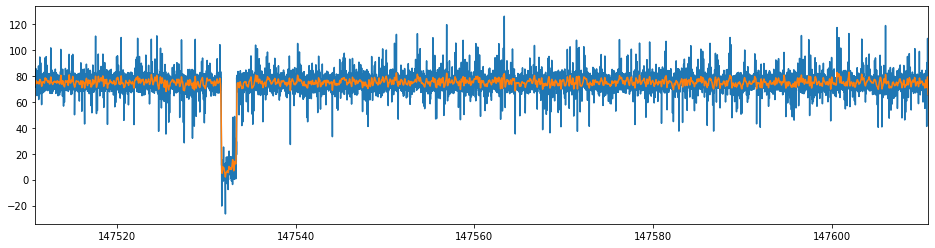

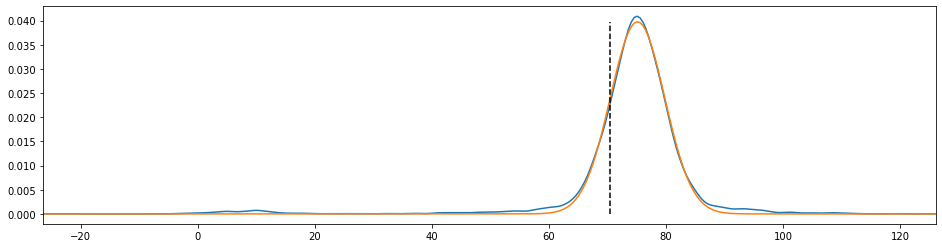

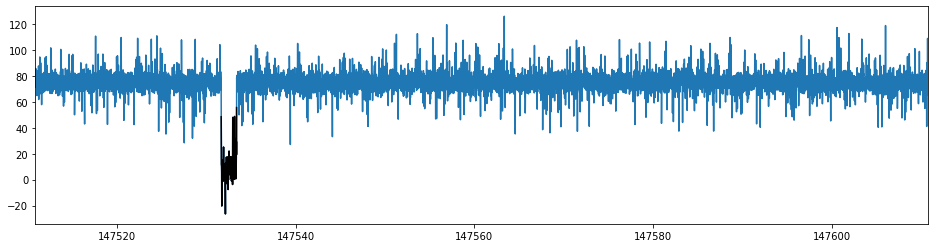

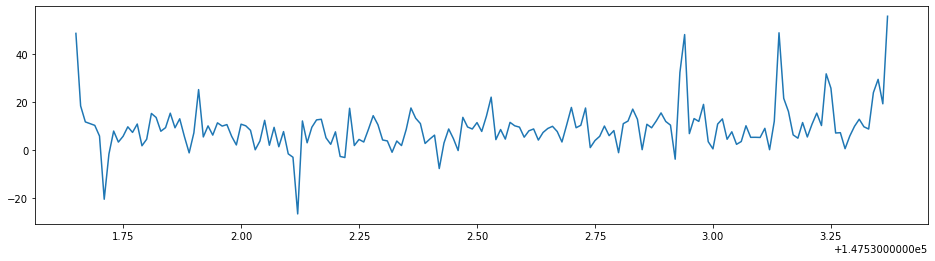

In [90]:
# parameters
lt = 100
res = 1.0
sigma_tol = 1.0
dt_res = dt*10

# random segement selection
n = int(lt / dt)
i0 = np.random.choice(len(t)-n)

# extract segement
ts = t[i0:i0+n]
Is = I[i0:i0+n]

# plot
plt.figure(figsize=(16,4))
plt.plot(ts, Is)
plt.plot(ts, smooth(Is,dt*1e-3))
plt.xlim(ts[0], ts[-1])
plt.show()

# distribution
Is_min, Is_max = np.min(Is), np.max(Is)
num_bins = int(np.ceil((Is_max-Is_min)/res))

# KDE
kde = KernelDensity(bandwidth=res)
kde.fit(Is.reshape(-1,1))

x = np.linspace(Is_min, Is_max, 2*num_bins)
h = np.exp(kde.score_samples(x.reshape(-1,1))).ravel()
h = h / np.sum(h)

# create guess for fit
guess = np.array([np.max(h), np.sum(x*h), 10.0])

# perform multi gauss fit
popt, pcov = curve_fit(gauss, x.astype(np.float64), h.astype(np.float64), p0=guess.astype(np.float64))
yf = gauss(x, popt[0], popt[1], popt[2])

# extract fit parameters
amp, mu, sigma = popt
mu, sigma

# plot
plt.figure(figsize=(16,4))
plt.plot(x,h)
plt.plot(x,yf)
plt.plot([mu-sigma_tol*sigma]*2, [0.0, amp], 'k--')
plt.xlim(Is_min, Is_max)
plt.show()

# event detection
I_thr = mu-sigma_tol*sigma
m = (Is < I_thr)
ids_l = split_discont_ids(np.where(m)[0])
ids_l = [ids for ids in ids_l if len(ids)*dt >= dt_res]

# plot
plt.figure(figsize=(16,4))
plt.plot(ts, Is)
for ids in ids_l:
    plt.plot(ts[ids], Is[ids], 'k-')
plt.xlim(ts[0], ts[-1])
plt.show()

plt.figure(figsize=(16,4))
for ids in ids_l:
    plt.plot(ts[ids], Is[ids])
plt.show()

In [73]:
# event detection
I_thr = mu-sigma_tol*sigma
m = (Is < I_thr)
ids_l = split_discont_ids(np.where(m)[0])
ids_l = [ids for ids in ids_l if len(ids)*dt >= dt_res]

In [17]:
dt_res / dt

10.0

In [18]:
np.array([ids[-1] for ids in ids_l])[:-1] - np.array([ids[0] for ids in ids_l])[1:]

array([-362])

In [19]:
np.array([ids[0] for ids in ids_l])[1:] - np.array([ids[-1] for ids in ids_l])[:-1]

array([362])

In [20]:
for i in range(len(ids_l)-1):
    print(ids_l[i])

[9474 9475 9476 9477 9478 9479 9480 9481 9482 9483 9484 9485 9486 9487
 9488 9489 9490 9491 9492 9493 9494 9495 9496 9497 9498]


In [21]:
ids_l

[array([9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484,
        9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495,
        9496, 9497, 9498]),
 array([9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9869, 9870,
        9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9879, 9880, 9881,
        9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892,
        9893, 9894, 9895, 9896, 9897, 9898, 9899, 9900, 9901, 9902, 9903,
        9904, 9905, 9906, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914,
        9915, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925,
        9926, 9927, 9928, 9929, 9930])]